In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import requests as req
import json


from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

new_path = os.getcwd().replace('/notebooks', '')
print(f'Adding {new_path} to sys.path')

if new_path not in sys.path:
    sys.path.append(new_path)

# Local imports
from curvemetrics.src.classes.datahandler import DataHandler
from curvemetrics.src.classes.datafetcher import DataFetcher
from curvemetrics.src.classes.metricsprocessor import MetricsProcessor
from curvemetrics.src.detection.bocd_stream.bocd.bocd import BayesianOnlineChangePointDetection
from curvemetrics.src.detection.bocd_stream.bocd.distribution import StudentT
from curvemetrics.src.detection.bocd_stream.bocd.hazard import ConstantHazard
from curvemetrics.src.detection.bocd_model import bocd, _constant_hazard, _log_likelihood_class
from curvemetrics.src.plotting.plot import bocd_plot_dm, bocd_plot, bocd_plot_comp
from curvemetrics.src.detection.scorer import true_positives, f_measure

Adding /root/curve-lp-metrics to sys.path
Use scipy logsumexp().


In [3]:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 10})

In [4]:
datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()

pool = "0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7" # 3pool

start_ts, start_block = DataFetcher.get_block(datetime.fromisoformat("2023-02-01"))
end_ts, end_block = DataFetcher.get_block(datetime.fromisoformat("2023-04-01"))

In [5]:
swaps_data = datahandler.get_swaps_data(pool, start_ts, end_ts)
lp_data = datahandler.get_lp_data(pool, start_ts, end_ts)
pool_data = datahandler.get_pool_data(pool, start_ts, end_ts)
tokens = {token_metadata[v]['symbol']:v for v in set(swaps_data['tokenBought'])}
ohlcvs = {}
for k, v in tokens.items():
    if k == "3Crv":
        continue
    ohlcv = datahandler.get_ohlcv_data(v, start=start_ts, end=end_ts)
    ohlcvs[v] = ohlcv

In [6]:
async def get_snapshots():
    datafetcher = DataFetcher(token_metadata=token_metadata)
    try:
        snapshots = datafetcher.get_snapshots(start_ts, end_ts, pool)
    except Exception as e:
        print(f'excepted: {e}')
        return 
    finally:
        await datafetcher.close()
    return snapshots
    
snapshots = await get_snapshots()
snapshots = DataHandler.format_pool_snapshots(snapshots)
snapshots = snapshots.sort_values(by='timestamp')
snapshots.index = snapshots['timestamp'].apply(datetime.fromtimestamp)

In [7]:
metricsprocessor = MetricsProcessor(pool_metadata, token_metadata, freq='1min')

pool_metrics = metricsprocessor.process_metrics_for_pool(pool, pool_data, swaps_data, lp_data, ohlcvs)
lp_share_price = metricsprocessor.lp_share_price(pool, pool_data, ohlcvs)
cps, error, vp, rp = metricsprocessor.true_cps(lp_share_price, snapshots)

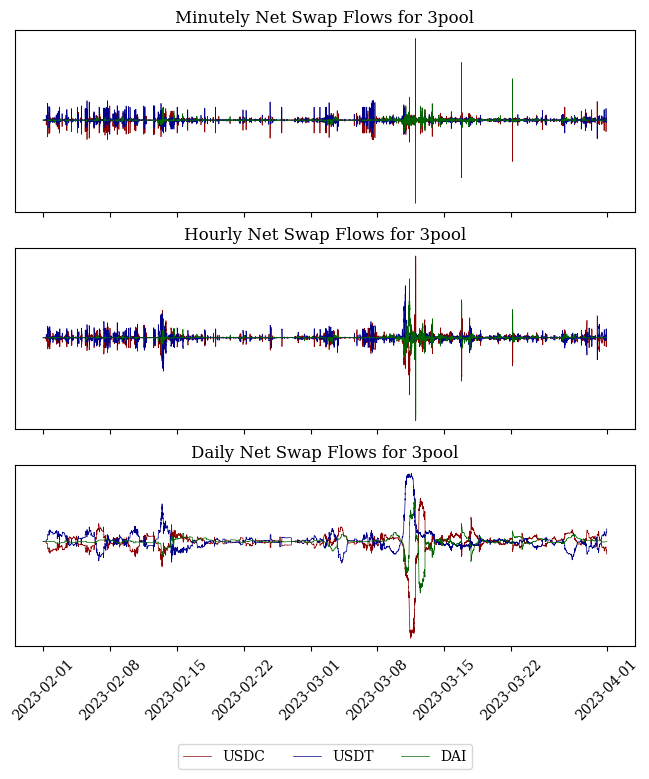

In [8]:
f, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

titles = ['Minutely', 'Hourly', 'Daily']
freqs = ['1min', '1h', '1d']

for i, ax in enumerate(axs):

    usdc_flow = pool_metrics['USDC.netSwapFlow'].rolling(freqs[i]).sum() / 1e6
    usdt_flow = pool_metrics['USDT.netSwapFlow'].rolling(freqs[i]).sum() / 1e6
    dai_flow = pool_metrics['DAI.netSwapFlow'].rolling(freqs[i]).sum() / 1e6

    ax.plot(usdc_flow.index, usdc_flow, label='USDC', linewidth=0.5, c='darkred')
    ax.plot(usdt_flow.index, usdt_flow, label='USDT', linewidth=0.5, c='darkblue')
    ax.plot(dai_flow.index, dai_flow, label='DAI', linewidth=0.5, c='darkgreen')

    # ax.grid(True)
    ax.set_title(f'{titles[i]} Net Swap Flows for 3pool')
    ax.set_yticks([])
    
ax.tick_params(axis='x', rotation=45)
axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=3)
f.savefig('../figs/3pool_swap_flows.png', bbox_inches='tight')

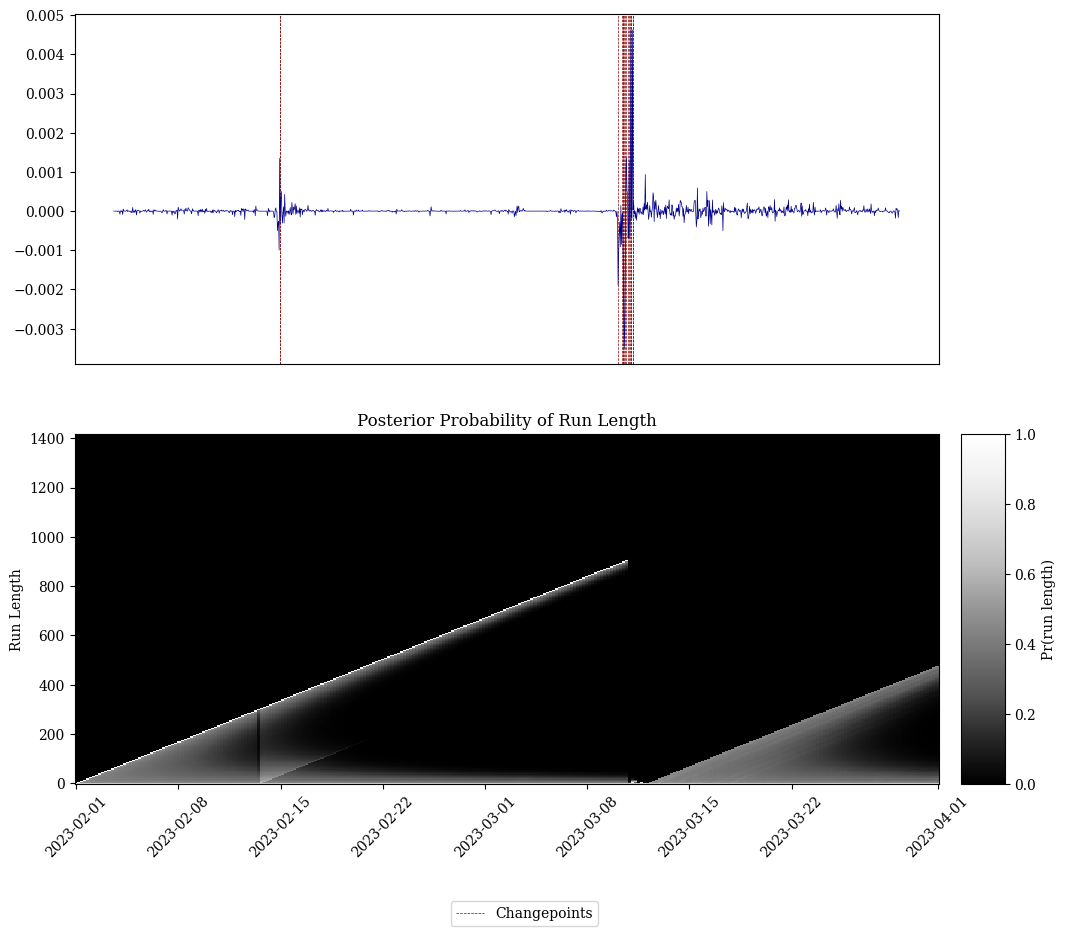

In [9]:
freq = '1h'
metric = np.log1p(pool_metrics['shannonsEntropy'].pct_change()).resample(freq).mean()
R, maxes = bocd(metric[:-1], alpha=1000, beta=0.0001, kappa=0.001)
peaks = np.where(maxes[:-1]!=maxes[1:]-1)[0]
bocd_plot_dm(metric, maxes, R, show=True)

In [18]:
model = BayesianOnlineChangePointDetection(ConstantHazard(100), StudentT(mu=0, kappa=0.001, alpha=1000, beta=0.0001))

In [19]:
metric = np.log1p(pool_metrics['shannonsEntropy'].pct_change()).dropna().resample('1h').mean()

# Online estimation and get the maximum likelihood r_t at each time point
count = 0
rt_mle = np.empty(metric.shape)
for i, d in enumerate(metric):
    model.update(d)
    rt_mle[i] = model.rt
    if count % 1000 == 0:
        print(f'count: {count}, beliefs: {model.beliefs.shape}')
    count += 1
pred_cps = metric.index[np.where(np.diff(rt_mle)!=1)[0]+1]

count: 0, beliefs: (2, 2)
count: 1000, beliefs: (66, 2)


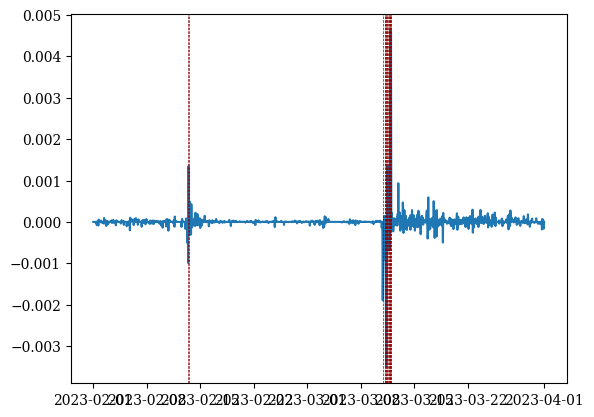

In [20]:
plt.plot(metric)
for cp in pred_cps:
    plt.axvline(cp, linestyle='--', linewidth=0.5, color='darkred')

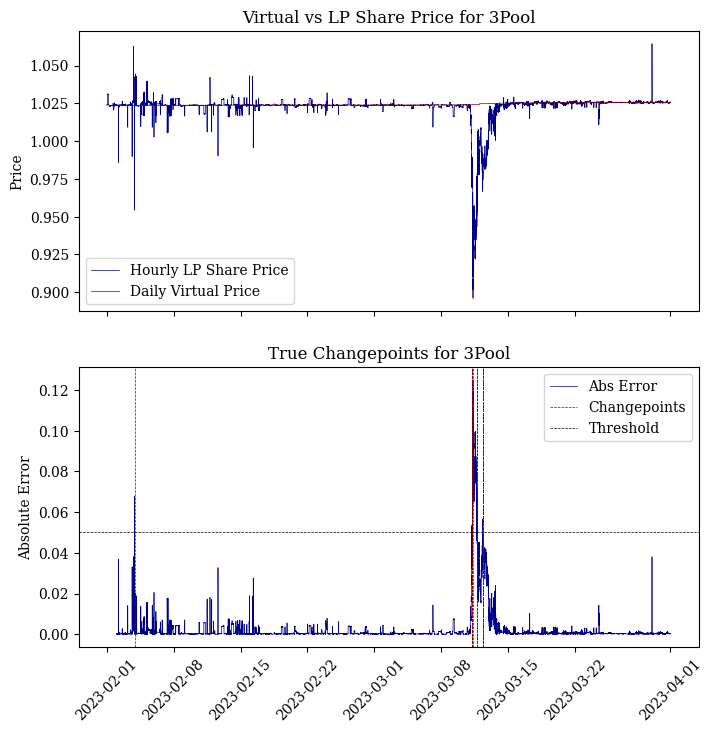

In [13]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

axs[0].plot(rp.index, rp, color='darkblue', linewidth=0.5, label='Hourly LP Share Price')  
axs[0].plot(vp.index, vp, color='darkred', linewidth=0.5, label='Daily Virtual Price')
axs[0].set_title('Virtual vs LP Share Price for 3Pool')
axs[0].legend()
axs[0].set_ylabel('Price')

axs[1].plot(error.index, error, color='darkblue', linewidth=0.5, label='Abs Error')

for cp in cps:
    axs[1].axvline(cp, linestyle='--', linewidth=0.5, color='darkred')
if len(cps):
    axs[1].plot([], [], label='Changepoints', color='darkred', linestyle='--', linewidth=0.5)
    
axs[1].axhline(0.05, linestyle='--', linewidth=0.5, color='black', label='Threshold')
axs[1].legend()
axs[1].tick_params(axis='x', rotation=45)
axs[1].set_title('True Changepoints for 3Pool')
axs[1].set_ylabel('Absolute Error')

f.savefig('../figs/3crv_cps', bbox_inches='tight')

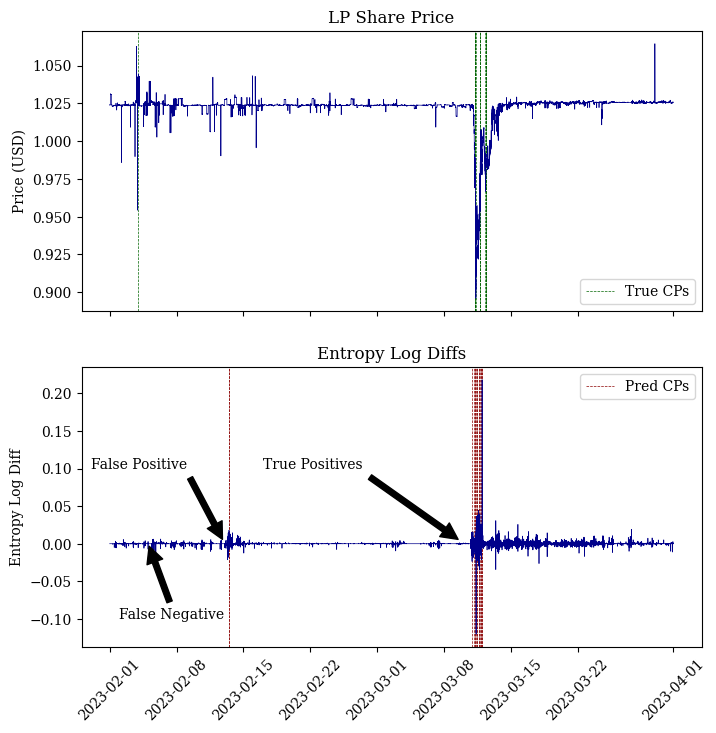

In [14]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

freq = '1min'

metric = np.log1p(pool_metrics['shannonsEntropy'].pct_change()).resample(freq).mean()

if len(cps):
    for cp in cps:
        axs[0].axvline(cp, linestyle='--', linewidth=0.5, color='darkgreen')
    axs[0].plot([], [], label='True CPs', color='darkgreen', linestyle='--', linewidth=0.5)

axs[0].plot(port.index, port, linewidth=0.5, c='darkblue')
axs[0].set_title('LP Share Price')
axs[0].set_ylabel('Price (USD)')
axs[0].legend()

if len(peaks):
    for peak in peaks[:-1]:
        axs[1].axvline(metric.index[peak*60], linestyle='--', color='darkred', linewidth=0.5)
    axs[1].plot([], [], color='darkred', linestyle='--', linewidth=0.5, label='Pred CPs')

axs[1].legend()

axs[1].plot(metric.index, metric, linewidth=0.5, c='darkblue')
axs[1].set_title('Entropy Log Diffs')
axs[1].set_ylabel('Entropy Log Diff')

axs[1].annotate('False Negative', xy=(19393, 0.001), xytext=(19390, -0.1),
            arrowprops=dict(facecolor='black', shrink=0.05))

axs[1].annotate('True Positives', xy=(19426, 0.001), xytext=(19405, 0.1),
            arrowprops=dict(facecolor='black', shrink=0.05))

axs[1].annotate('False Positive', xy=(19401, 0.001), xytext=(19387, 0.1),
            arrowprops=dict(facecolor='black', shrink=0.05))

axs[1].tick_params(axis='x', rotation=45)

f.savefig('../figs/lp_cps_3crv.png', bbox_inches='tight')
plt.show()

# Grid Search

In [65]:
alpha = [10**i for i in range(1, 5)]
beta = [10**i for i in range(-4, 0)]
kappa = [10**i for i in range(-4, 0)]

grid = [[a, b, k] for a in alpha for b in beta for k in kappa]
print(len(grid))

64


In [66]:
import multiprocessing as mp

def predict(metric, params):

    model = BayesianOnlineChangePointDetection(
        ConstantHazard(params['lambda']), 
        StudentT(mu=params['mu'], 
        kappa=params['kappa'], 
        alpha=params['alpha'], 
        beta=params['beta'])
    )

    rt_mle = np.empty(metric.shape)
    for i, d in enumerate(metric):
        model.update(d)
        rt_mle[i] = model.rt

    return metric.index[np.where(np.diff(rt_mle)!=1)[0]+1]

def process_chunk(chunk, metric, cps):
    results = {}
    for a, b, k in chunk:
        params = {'lambda': 100, 'alpha': a, 'beta': b, 'kappa': k, 'mu': 0}
        pred = predict(metric, params)
        if len(pred) == 0:
            continue
        results[(a, b, k)] = f_measure({1: cps}, pred, margin=timedelta(hours=24), alpha=1/5, return_PR=True)
    return results

def parallel_process(grid, metric, cps):
    num_cpus = mp.cpu_count()
    chunk_size = len(grid) // num_cpus
    chunks = [grid[i:i + chunk_size] for i in range(0, len(grid), chunk_size)]

    pool = mp.Pool(processes=num_cpus)
    results = pool.starmap(process_chunk, [(chunk, metric, cps) for chunk in chunks])
    pool.close()
    pool.join()

    merged_results = {}
    for result in results:
        merged_results.update(result)

    return merged_results

freq = '1h'
metric = np.log1p(pool_metrics['shannonsEntropy'].pct_change()).dropna().resample(freq).mean()
port = lp_share_price.resample(freq).mean()
results = parallel_process(grid, metric, cps)
print(len(results))

/root/curve-lp-metrics/venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6703: RuntimeWarning: overflow encountered in power
  / (np.sqrt(df*np.pi)*(1+(x**2)/df)**((df+1)/2))


29


(1000, 0.0001, 0.001)
(0.7407407407407406, 0.7058823529411765, 0.75)


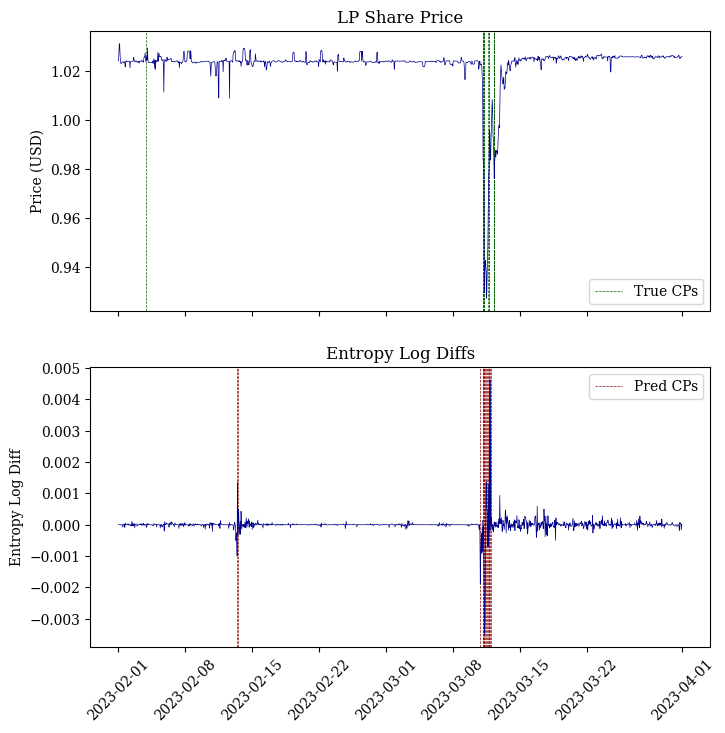

In [70]:
a, b, k = max(results, key=lambda x: results[x][0])
print((a, b, k))
print(results[(a, b, k)])
R, maxes = bocd(metric[:-1], alpha=a, beta=b, kappa=k)
peaks = np.where(maxes[:-1]!=maxes[1:]-1)[0][:-1]
bocd_plot_comp(metric, port, cps, peaks)

(0.1515151515151515, 1.0, 0.125)


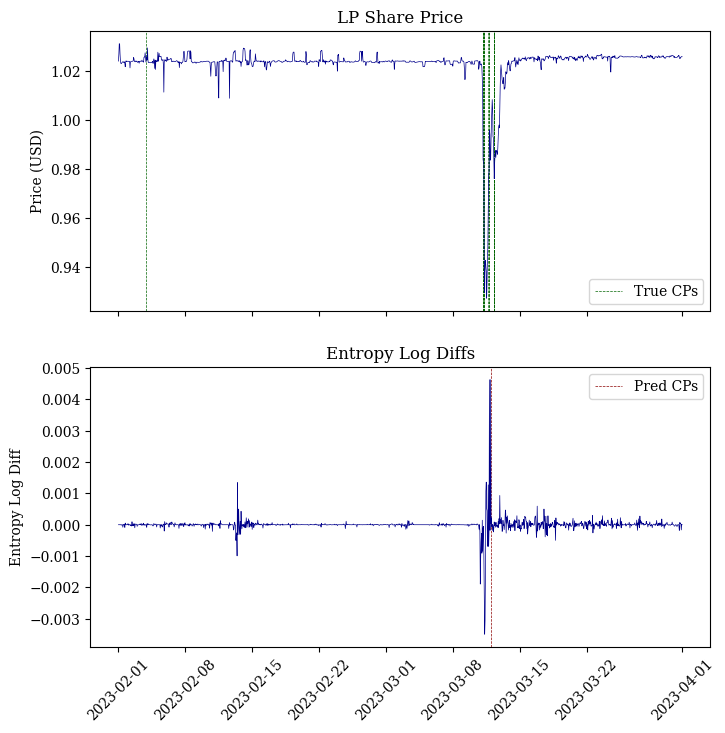

In [71]:
a, b, k = max(results, key=lambda x: results[x][1])
print(results[(a, b, k)])
R, maxes = bocd(metric[:-1], alpha=a, beta=b, kappa=k)
peaks = np.where(maxes[:-1]!=maxes[1:]-1)[0][:-1]
bocd_plot_comp(metric, port, cps, peaks)

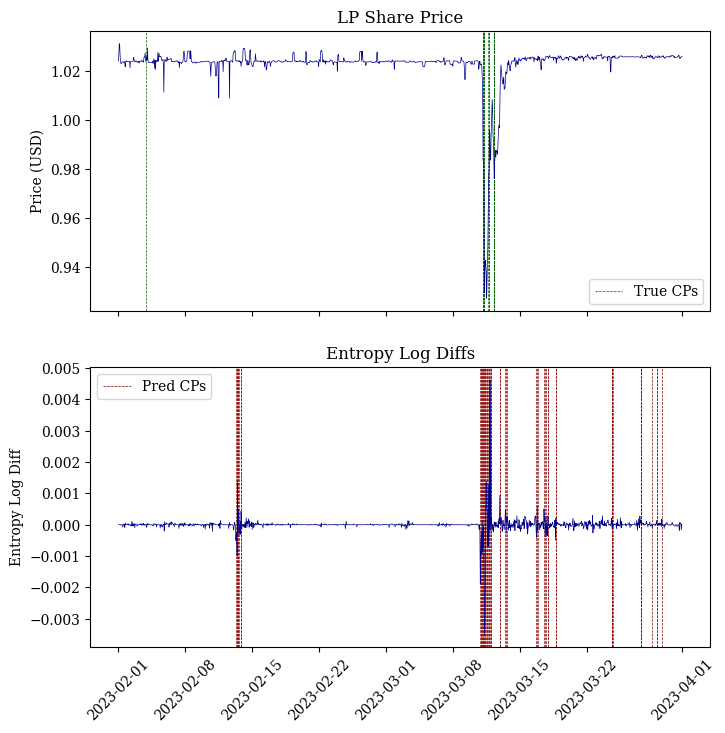

In [72]:
a, b, k = max(results, key=lambda x: results[x][2])
R, maxes = bocd(metric[:-1], alpha=a, beta=b, kappa=k)
peaks = np.where(maxes[:-1]!=maxes[1:]-1)[0][:-1]
bocd_plot_comp(metric, port, cps, peaks)